## Importing Necessary Libraries

In [317]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from scipy import stats
import time
import os

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

In [318]:
data = pd.read_csv('4. Data/application_train.csv')
print(data.shape)
data.head(3)

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


The testing Data Don't have the Target variable. 

In [320]:
list(data.columns)

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

## Exploratory Data Analysis

In [322]:
data['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

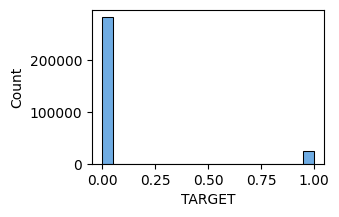

In [323]:
plt.figure(figsize=(3,2))
sns.histplot(data['TARGET'])
plt.show()

Here we can see that the problem is of type **Imbalanced Class Problem**

In [325]:
import pandas as pd

# Create a list to store the results
missing_data = []

# Iterate over columns and calculate missing value percentages
for column in data.columns:
    missing_count = data[column].isnull().sum()
    if missing_count > 0:
        percentage = 100 * missing_count / len(data)
        missing_data.append([column, missing_count, percentage])

# Create a DataFrame from the results
missing_df = pd.DataFrame(missing_data, columns=['Columns', 'Missing Count', 'Missing Percentage'])

# Format the percentage column to 3 decimal places
missing_df['Missing Percentage'] = missing_df['Missing Percentage'].round(3)

pd.set_option('display.max_rows', None)
# Display the DataFrame
missing_df.head()

,Columns,Missing Count,Missing Percentage
0,AMT_ANNUITY,12,0.004
1,AMT_GOODS_PRICE,278,0.090
2,NAME_TYPE_SUITE,1292,0.420
3,OWN_CAR_AGE,202929,65.991
4,OCCUPATION_TYPE,96391,31.346


In [326]:
# Number of each type of column
data.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [327]:
# Number of unique classes in each object column
data.select_dtypes('object').nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [328]:
data.select_dtypes('object').nunique()[list(data.select_dtypes('object').nunique() <= 2)]

NAME_CONTRACT_TYPE     2
FLAG_OWN_CAR           2
FLAG_OWN_REALTY        2
EMERGENCYSTATE_MODE    2
dtype: int64

In [329]:
# label encoding only categorical columns having only 2 or less categories

le = LabelEncoder()
le_count = 0

for col in data:
    if data[col].dtype == 'object':
        if len(list(data[col].unique())) <= 2:
            le.fit(data[col])
            data[col] = le.transform(data[col])
            le_count += 1
print(f'{le_count} columns were label encoded.')           

3 columns were label encoded.


In [330]:
data['EMERGENCYSTATE_MODE'].head()

0     No
1     No
2    NaN
3    NaN
4    NaN
Name: EMERGENCYSTATE_MODE, dtype: object

In [331]:
data = pd.get_dummies(data)

In [332]:
data.shape

(307511, 243)

In [333]:
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,False,False,False,False,False,False,True,False,True,False
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,False,True,False,False,False,False,False,False,True,False
2,100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,False,False,False,False,False,False,False,False,False,False
3,100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,False,False,False,False,False,False,False,False,False,False
4,100007,0,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,False,False,False,False,False,False,False,False,False,False


## Anomaly Detection:

In [335]:
(data['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Seems to be no outliers in the Days_Birth Column.

In [337]:
(data['DAYS_EMPLOYED']/365).describe()

count    307511.000000
mean        174.835742
std         387.056895
min         -49.073973
25%          -7.561644
50%          -3.323288
75%          -0.791781
max        1000.665753
Name: DAYS_EMPLOYED, dtype: float64

Well, the maximum value is 1000 years which is an indication of presence of outliers.

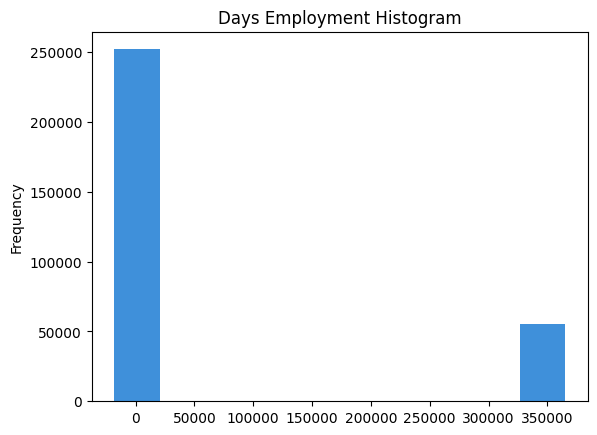

In [339]:
data['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');

Just out of curiousity, let's subset the anomalous clients and see if they tend to have higher or low rates of default than the rest of the clients.

In [341]:
anom = data[data['DAYS_EMPLOYED'] == 365243]
non_anom = data[data['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Well that is extremely interesting! It turns out that the anomalies have a lower rate of default.

Handling the anomalies depends on the exact situation, with no set rules. One of the safest approaches is just to set the anomalies to a missing value and then have them filled in (using Imputation) before machine learning. In this case, since all the anomalies have the exact same value, we want to fill them in with the same value in case all of these loans share something in common. The anomalous values seem to have some importance, so we want to tell the machine learning model if we did in fact fill in these values. As a solution, we will fill in the anomalous values with not a number (np.nan) and then create a new boolean column indicating whether or not the value was anomalous.

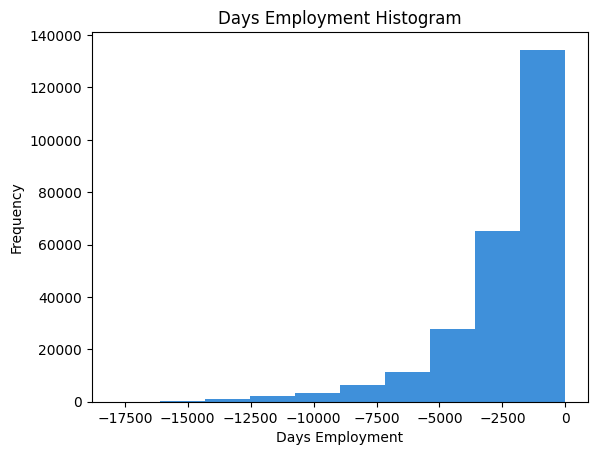

In [343]:
# Create an anomalous flag column
data['DAYS_EMPLOYED_ANOM'] = data["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
data['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

data['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

The distribution looks to be much more in line with what we would expect, and we also have created a new column to tell the model that these values were originally anomalous (becuase we will have to fill in the nans with some value, probably the median of the column). The other columns with DAYS in the dataframe look to be about what we expect with no obvious outliers.

As an extremely important note, anything we do to the training data we also have to do to the testing data. Let's make sure to create the new column and fill in the existing column with np.nan in the testing data.

### Correlations
Now that we have dealt with the categorical variables and the outliers, let's continue with the EDA. One way to try and understand the data is by looking for correlations between the features and the target. We can calculate the Pearson correlation coefficient between every variable and the target using the .corr dataframe method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some general interpretations of the absolute value of the correlation coefficent are:

In [346]:
# Find correlations with the target and sort
correlations = data.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

Let's take a look at some of more significant correlations: the DAYS_BIRTH is the most positive correlation. (except for TARGET because the correlation of a variable with itself is always 1!) Looking at the documentation, DAYS_BIRTH is the age in days of the client at the time of the loan in negative days (for whatever reason!). The correlation is positive, but the value of this feature is actually negative, meaning that as the client gets older, they are less likely to default on their loan (ie the target == 0). That's a little confusing, so we will take the absolute value of the feature and then the correlation will be negative.

### Effect of Age on Repayment

In [349]:
# Find the correlation of the positive days since birth and target
data['DAYS_BIRTH'] = abs(data['DAYS_BIRTH'])
data['DAYS_BIRTH'].corr(data['TARGET'])

-0.07823930830982709

As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often.

Let's start looking at this variable. First, we can make a histogram of the age. We will put the x axis in years to make the plot a little more understandable.

In [351]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


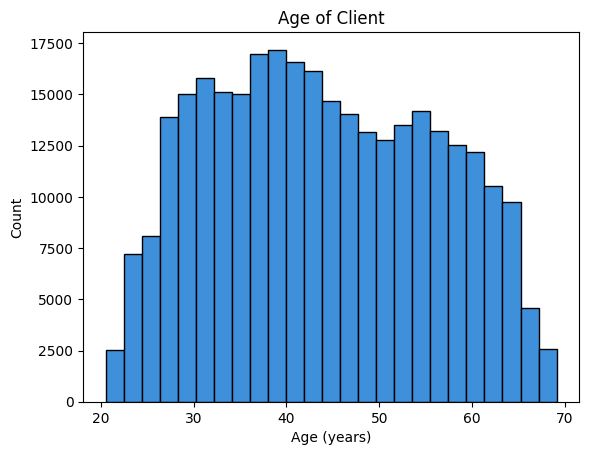

In [352]:
# Set the style of plots
plt.style.use('petroff10')

# Plot the distribution of ages in years
plt.hist(data['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

By itself, the distribution of age does not tell us much other than that there are no outliers as all the ages are reasonable. To visualize the effect of the age on the target, we will next make a kernel density estimation plot (KDE) colored by the value of the target. A kernel density estimate plot shows the distribution of a single variable and can be thought of as a smoothed histogram (it is created by computing a kernel, usually a Gaussian, at each data point and then averaging all the individual kernels to develop a single smooth curve). We will use the seaborn kdeplot for this graph.

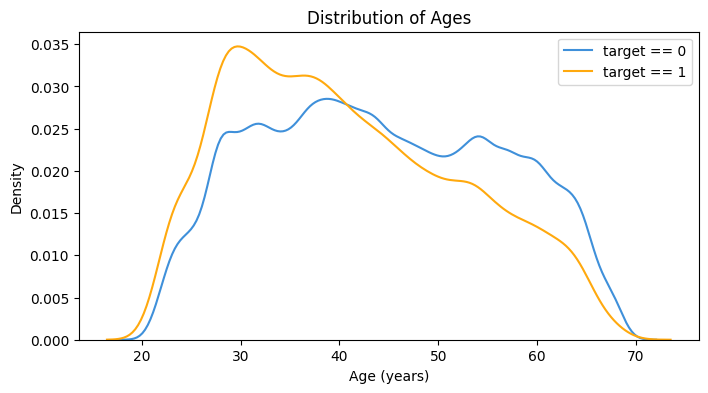

In [354]:
plt.figure(figsize = (8, 4))

# KDE plot of loans that were repaid on time
sns.kdeplot(data.loc[data['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(data.loc[data['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages')
plt.legend();

The target == 1 curve skews towards the younger end of the range. Although this is not a significant correlation (-0.07 correlation coefficient), this variable is likely going to be useful in a machine learning model because it does affect the target. Let's look at this relationship in another way: average failure to repay loans by age bracket.

To make this graph, first we cut the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

In [356]:
# Age information into a separate dataframe
age_data = data[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [357]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


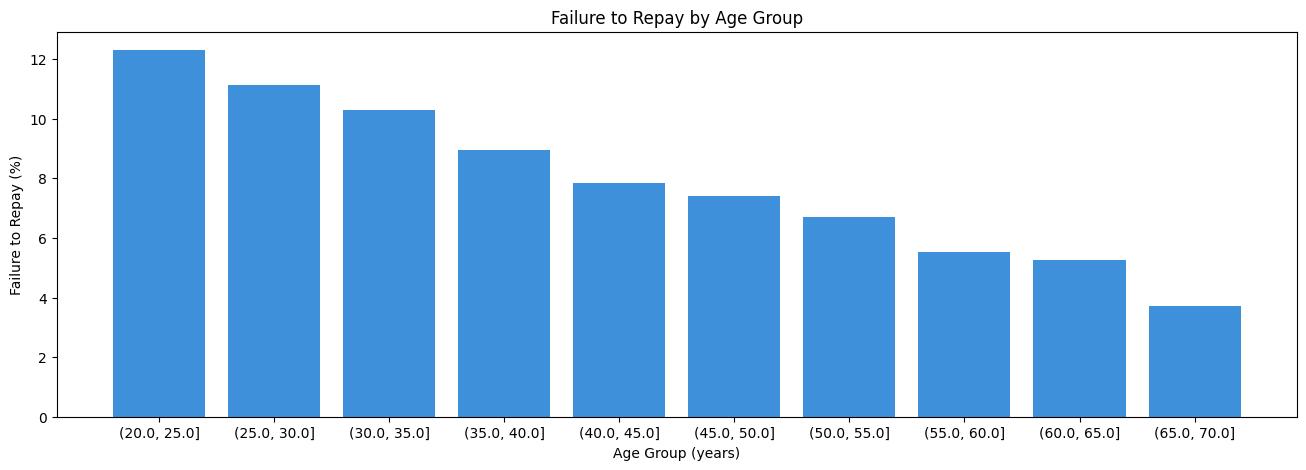

In [358]:
plt.figure(figsize = (16, 5))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 0); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

There is a clear trend: younger applicants are more likely to not repay the loan! The rate of failure to repay is above 10% for the youngest three age groups and below 5% for the oldest age group.

This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.

### Exterior Sources:
The 3 variables with the strongest negative correlations with the target are EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3. According to the documentation, these features represent a "normalized score from external data source". I'm not sure what this exactly means, but it may be a cumulative sort of credit rating made using numerous sources of data.

Let's take a look at these variables.

First, we can show the correlations of the EXT_SOURCE features with the target and with each other.

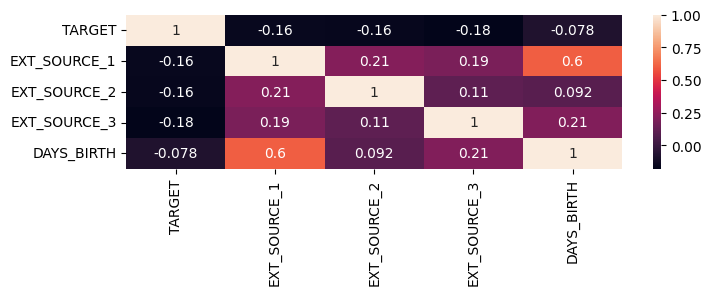

In [361]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = data[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()

plt.figure(figsize=(8,2))
sns.heatmap(ext_data_corrs, annot=True)
plt.show()

All three EXT_SOURCE features have negative correlations with the target, indicating that as the value of the EXT_SOURCE increases, the client is more likely to repay the loan. We can also see that DAYS_BIRTH is positively correlated with EXT_SOURCE_1 indicating that maybe one of the factors in this score is the client age.

Next we can look at the distribution of each of these features colored by the value of the target. This will let us visualize the effect of this variable on the target.

EXT_SOURCE_3 displays the greatest difference between the values of the target. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is not very strong (in fact they are all considered very weak, but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time.

### Pairs Plot
As a final exploratory plot, we can make a pairs plot of the EXT_SOURCE variables and the DAYS_BIRTH variable. The Pairs Plot is a great exploration tool because it lets us see relationships between multiple pairs of variables as well as distributions of single variables. Here we are using the seaborn visualization library and the PairGrid function to create a Pairs Plot with scatterplots on the upper triangle, histograms on the diagonal, and 2D kernel density plots and correlation coefficients on the lower triangle.

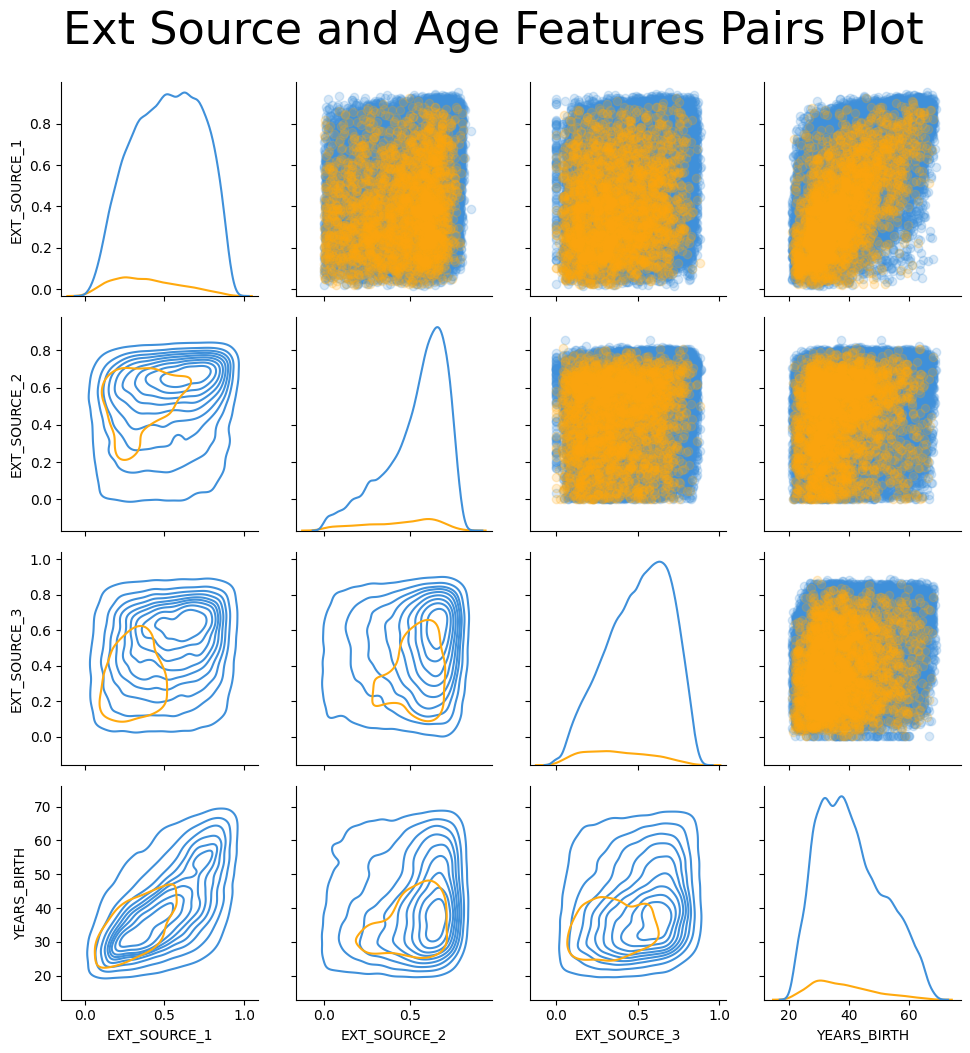

In [365]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

In this plot, the yellow indicates loans that were not repaid and the blue are loans that are paid. We can see the different relationships within the data. There does appear to be a moderate positive linear relationship between the EXT_SOURCE_1 and the DAYS_BIRTH (or equivalently YEARS_BIRTH), indicating that this feature may take into account the age of the client.

## Feature Engineering
Kaggle competitions are won by feature engineering: those win are those who can create the most useful features out of the data. (This is true for the most part as the winning models, at least for structured data, all tend to be variants on gradient boosting). This represents one of the patterns in machine learning: feature engineering has a greater return on investment than model building and hyperparameter tuning. This is a great article on the subject). As Andrew Ng is fond of saying: "applied machine learning is basically feature engineering."

While choosing the right model and optimal settings are important, the model can only learn from the data it is given. Making sure this data is as relevant to the task as possible is the job of the data scientist (and maybe some automated tools to help us out).

Feature engineering refers to a geneal process and can involve both feature construction: adding new features from the existing data, and feature selection: choosing only the most important features or other methods of dimensionality reduction. There are many techniques we can use to both create features and select features.

We will do a lot of feature engineering when we start using the other data sources, but in this notebook we will try only two simple feature construction methods:

- Polynomial features
- Domain knowledge features

### Polynomial Features
One simple feature construction method is called polynomial features. In this method, we make features that are powers of existing features as well as interaction terms between existing features. For example, we can create variables EXT_SOURCE_1^2 and EXT_SOURCE_2^2 and also variables such as EXT_SOURCE_1 x EXT_SOURCE_2, EXT_SOURCE_1 x EXT_SOURCE_2^2, EXT_SOURCE_1^2 x EXT_SOURCE_2^2, and so on. These features that are a combination of multiple individual variables are called interaction terms because they capture the interactions between variables. In other words, while two variables by themselves may not have a strong influence on the target, combining them together into a single interaction variable might show a relationship with the target. Interaction terms are commonly used in statistical models to capture the effects of multiple variables, but I do not see them used as often in machine learning. Nonetheless, we can try out a few to see if they might help our model to predict whether or not a client will repay a loan.

Jake VanderPlas writes about polynomial features in his excellent book Python for Data Science for those who want more information.

In the following code, we create polynomial features using the EXT_SOURCE variables and the DAYS_BIRTH variable. Scikit-Learn has a useful class called PolynomialFeatures that creates the polynomials and the interaction terms up to a specified degree. We can use a degree of 3 to see the results (when we are creating polynomial features, we want to avoid using too high of a degree, both because the number of features scales exponentially with the degree, and because we can run into problems with overfitting).

In [369]:
# Make a new dataframe for polynomial features
poly_features = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
poly_target = data[['TARGET']]

In [370]:
# imputer for handling missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)

In [371]:
from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [372]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)

print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [373]:
poly_transformer.get_feature_names_out(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])

array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2', 'EXT_SOURCE_1^3',
       'EXT_SOURCE_1^2 EXT_SOURCE_2', 'EXT_SOURCE_1^2 EXT_SOURCE_3',
       'EXT_SOURCE_1^2 DAYS_BIRTH', 'EXT_SOURCE_1 EXT_SOURCE_2^2',
       'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH',
       'EXT_SOURCE_1 EXT_SOURCE_3^2',
       'EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH',
       'EXT_SOURCE_1 DAYS_BIRTH^2', 'EXT_SOURCE_2^3',
       'EXT_SOURCE_2^2 EXT_SOURCE_3', 'EXT_SOURCE_2^2 DAYS_BIRTH',
       'EXT_SOURCE_2 EXT_SOURCE_3^2',
       'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH',
       'EXT_SOURCE_2 DAYS_BIRTH^2', 'EXT_SOURCE_3^3',
       'EXT_SOURCE_3^2 DAYS_BIRTH', 'EXT_SOURCE_3 DAYS_BIR

There are 35 features with individual features raised to powers up to degree 3 and interaction terms. Now, we can see whether any of these new features are correlated with the target.


In [375]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


Several of the new variables have a greater (in terms of absolute magnitude) correlation with the target than the original features. When we build machine learning models, we can try with and without these features to determine if they actually help the model learn.

We will add these features to a copy of the training and testing data and then evaluate models with and without the features. Many times in machine learning, the only way to know if an approach will work is to try it out!

In [377]:
# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = data['SK_ID_CURR']
data_poly = data.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Print out the new shape
print('data with polynomial features shape: ', data_poly.shape)


data with polynomial features shape:  (307511, 280)


### Domain Knowledge Features:
Maybe it's not entirely correct to call this "domain knowledge" because I'm not a credit expert, but perhaps we could call this "attempts at applying limited financial knowledge". In this frame of mind, we can make a couple features that attempt to capture what we think may be important for telling whether a client will default on a loan. Here I'm going to use five features that were inspired by this script by Aguiar:

- CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income
- ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income
- CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due
- DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age

Again, thanks to Aguiar and his great script for exploring these features.

In [379]:
data_domain = data.copy()

data_domain['CREDIT_INCOME_PERCENT'] = data_domain['AMT_CREDIT'] / data_domain['AMT_INCOME_TOTAL']
data_domain['ANNUITY_INCOME_PERCENT'] = data_domain['AMT_ANNUITY'] / data_domain['AMT_INCOME_TOTAL']
data_domain['CREDIT_TERM'] = data_domain['AMT_ANNUITY'] / data_domain['AMT_CREDIT']
data_domain['DAYS_EMPLOYED_PERCENT'] = data_domain['DAYS_EMPLOYED'] / data_domain['DAYS_BIRTH']

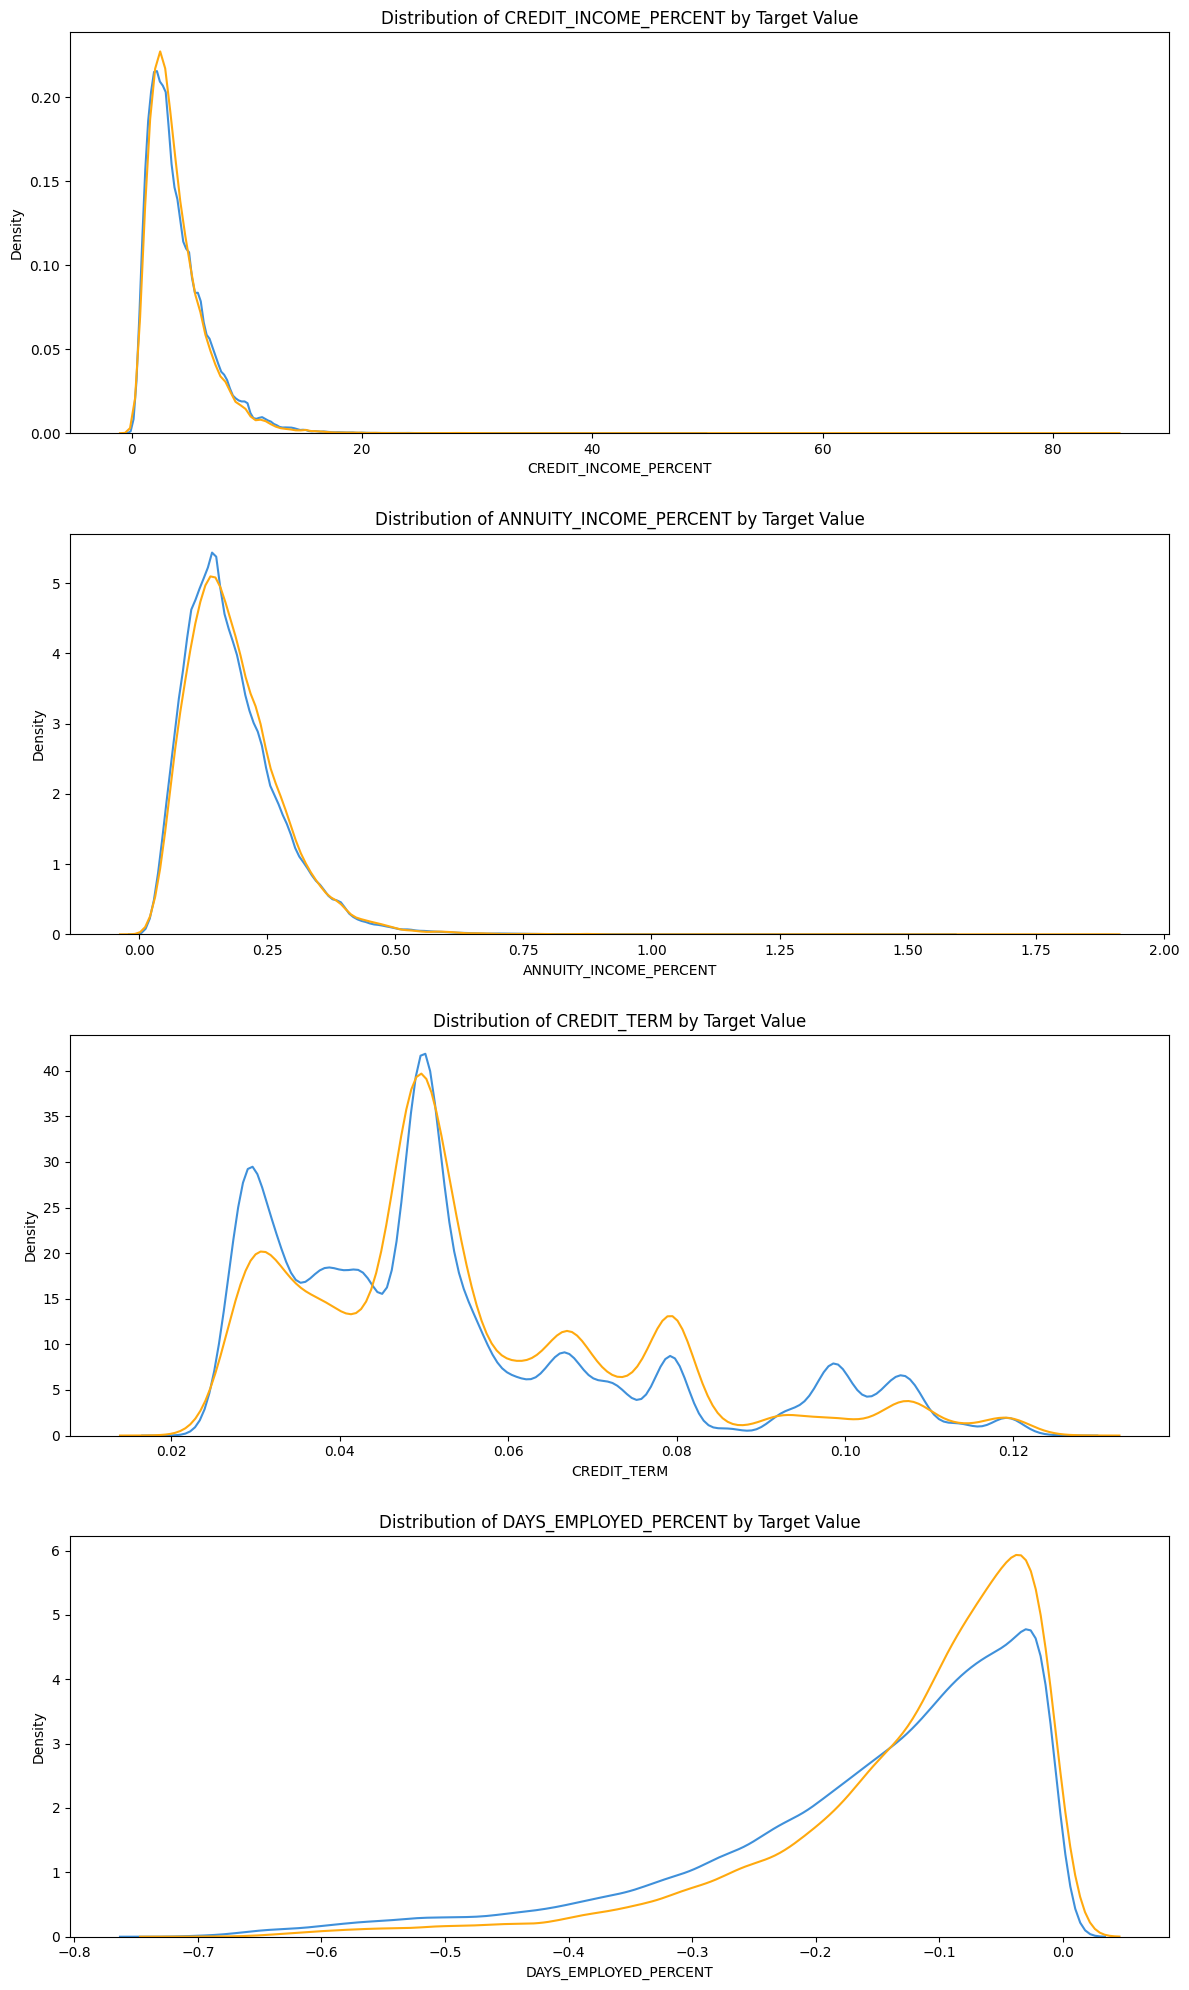

In [380]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(data_domain.loc[data_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(data_domain.loc[data_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

It's hard to say ahead of time if these new features will be useful. The only way to tell for sure is to try them out!

### Baseline

For a naive baseline, we could guess the same value for all examples on the testing set. We are asked to predict the probability of not repaying the loan, so if we are entirely unsure, we would guess 0.5 for all observations on the test set. This will get us a Reciever Operating Characteristic Area Under the Curve (AUC ROC) of 0.5 in the competition (random guessing on a classification task will score a 0.5).

Since we already know what score we are going to get, we don't really need to make a naive baseline guess. Let's use a slightly more sophisticated model for our actual baseline: Logistic Regression.

### Logistic Regression Implementation
Here I will focus on implementing the model rather than explaining the details, but for those who want to learn more about the theory of machine learning algorithms, I recommend both An Introduction to Statistical Learning and Hands-On Machine Learning with Scikit-Learn and TensorFlow. Both of these books present the theory and also the code needed to make the models (in R and Python respectively). They both teach with the mindset that the best way to learn is by doing, and they are very effective!

To get a baseline, we will use all of the features after encoding the categorical variables. We will preprocess the data by filling in the missing values (imputation) and normalizing the range of the features (feature scaling). The following code performs both of these preprocessing steps.

In [384]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Drop the target from the data
target = data['TARGET']
df_ML = data.drop(columns = ['TARGET'])

    
# Feature names
features = list(df_ML.columns)

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the data
imputer.fit(df_ML)

# Transform data
df_ML = imputer.transform(df_ML)

# Repeat with the scaler
scaler.fit(df_ML)
df_ML = scaler.transform(df_ML)

print('Training data shape: ', df_ML.shape)

Training data shape:  (307511, 243)


In [385]:
X_train, X_test, y_train, y_test = train_test_split(df_ML, target, test_size = 0.2, stratify=target)

In [386]:
log_reg = LogisticRegression(C = 0.0001)
# Train on the training data
log_reg.fit(X_train, y_train)

LogisticRegression(C=0.0001)

In [387]:
log_reg_pred = log_reg.predict_proba(X_test)[:, 1]

### Defining Business Cost:
 Define business cost values for false positives and false negatives.

In [439]:
avg_loan = int(data['AMT_CREDIT'].mean())

avg_loan

599025

In [443]:
#  calculate the average estimated interest income for non-defaulting borrowers

# Filter only non-defaulting clients (TARGET == 0)
df_good = data[data['TARGET'] == 0].copy()

# Avoid division by zero or missing annuity
df_good = df_good[(df_good['AMT_ANNUITY'] > 0) & (df_good['AMT_CREDIT'].notna()) & (df_good['AMT_ANNUITY'].notna())]

# Estimate number of payments (months)
df_good['N_PAYMENTS'] = np.ceil(df_good['AMT_CREDIT'] / df_good['AMT_ANNUITY'])

# Total amount paid over loan term
df_good['TOTAL_PAID'] = df_good['AMT_ANNUITY'] * df_good['N_PAYMENTS']

# Estimate interest income
df_good['INTEREST_INCOME_EST'] = df_good['TOTAL_PAID'] - df_good['AMT_CREDIT']

# Calculate average interest income per good borrower
avg_interest_income = int(df_good['INTEREST_INCOME_EST'].mean())

print(f"Estimated Average Interest Income per Good Borrower: ${avg_interest_income:,.2f}")


Estimated Average Interest Income per Good Borrower: $13,135.00


In [459]:
# calculating recovery rate from installments_payments data

# Load installments data
inst = pd.read_csv('4. Data/installments_payments.csv')

# Get defaulting IDs
defaulters_ids = data[data['TARGET'] == 1]['SK_ID_CURR'].unique()

# Filter only defaulting customers' payments
inst_defaulters = inst[inst['SK_ID_CURR'].isin(defaulters_ids)]

# Total paid per customer
total_paid = inst_defaulters.groupby('SK_ID_CURR')['AMT_PAYMENT'].sum()

# Get their credit amounts
credit_amounts = data[data['TARGET'] == 1][['SK_ID_CURR', 'AMT_CREDIT']].drop_duplicates().set_index('SK_ID_CURR')

# Join and compute recovery rate
merged = credit_amounts.join(total_paid.rename('TOTAL_PAID'), how='inner')
merged['RECOVERY_RATE'] = merged['TOTAL_PAID'] / merged['AMT_CREDIT']

merged['RECOVERY_RATE'].describe()

count    23876.000000
mean         1.422757
std          2.580747
min          0.000000
25%          0.220994
50%          0.576869
75%          1.579926
max         76.862046
Name: RECOVERY_RATE, dtype: float64

- The mean recovery rate is 1.42, or 142%, which is not realistic.
- Max is 7,686% — this is definitely a data error or artifact.
- Recovery rates should realistically be in the 0 to 1 range (0% to 100%).

In [463]:
# Clip recovery rates to a maximum of 1.0 (100%)
merged['RECOVERY_RATE'] = merged['RECOVERY_RATE'].clip(upper=1.0)

# Optional: Also drop rows where AMT_CREDIT is too small or recovery is 0 (if noisy)
merged = merged[merged['RECOVERY_RATE'] >= 0.01]

# Now recalculate mean recovery rate
average_recovery_rate = merged['RECOVERY_RATE'].mean()

print(f"Cleaned average recovery rate: {average_recovery_rate:.2%}")

Cleaned average recovery rate: 59.18%


In [472]:
cost_fp = avg_interest_income

avg_loan_amount = data[data['TARGET'] == 1]['AMT_CREDIT'].mean() 
cost_fn = int(avg_loan_amount * (1 - average_recovery_rate))

from sklearn.metrics import confusion_matrix

def business_cost(y_true, y_pred, cost_fp, cost_fn):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_cost = fp * cost_fp + fn * cost_fn
    return total_cost


In [478]:
print('cost_fp: ', cost_fp)
print('cost_fn: ', cost_fn)

cost_fp:  13135
cost_fn:  227665


**This Means**
The model should:

- Be very cautious about false negatives — they’re ~17x more expensive than false positives.
- Allow more false positives if it helps reduce false negatives (i.e., accept more borderline borrowers).

This has a direct impact on:

- Model threshold tuning
- Evaluation metrics (e.g., prioritize cost, not just accuracy or F1-score)
- Business decisions — like underwriting policy or referral to manual review

In [480]:
def business_cost(y_true, y_pred, cost_fp=13135, cost_fn=227665):
    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (fp * cost_fp) + (fn * cost_fn)

In [496]:
thresholds = np.linspace(0, 0.9, 100)
costs = []

for t in thresholds:
    y_pred = (log_reg.predict_proba(X_test)[:, 1] >= t).astype(int)
    cost = business_cost(y_test, y_pred)
    costs.append(cost)

best_threshold = thresholds[np.argmin(costs)]
print(f"Best threshold to minimize cost: {best_threshold:.2f}")

Best threshold to minimize cost: 0.07


Why 0.07 is Optimal:
- The false negative cost (\\$227,665) is massively higher than false positive cost (\\$13,135).
- So the model is incentivized to "play it safe":
    - It will flag more people as potential defaulters (i.e., label more as 1)
    - Even if that increases false positives, it reduces false negatives, which matter more financially.

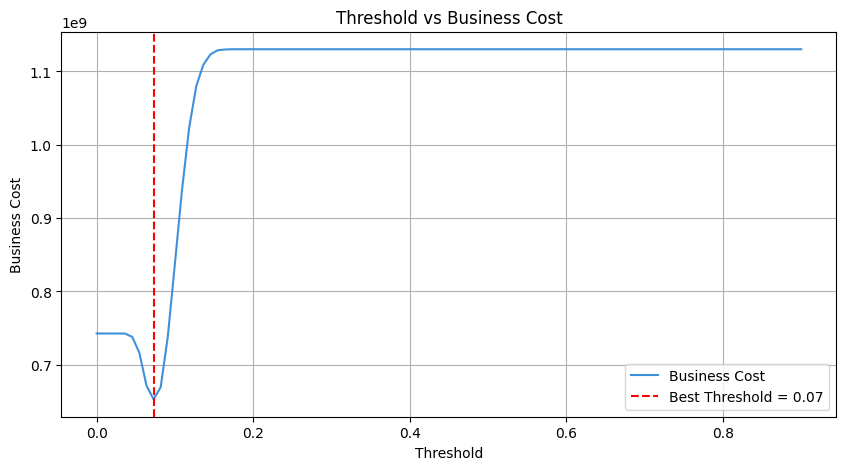

In [498]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, costs, label='Business Cost')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Business Cost')
plt.title('Threshold vs Business Cost')
plt.legend()
plt.grid(True)
plt.show()

In [500]:
# Updating Model’s Prediction Logic
y_final_pred = (log_reg.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)

In [502]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_final_pred)
print("Confusion Matrix at Optimal Threshold:\n", cm)

Confusion Matrix at Optimal Threshold:
 [[22181 34357]
 [  886  4079]]
